In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import os
import sys
import numpy as np
import pandas as pd
from scipy.signal import detrend

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.environ.get('projdir'),'src')
sys.path.append(src_dir)
from features.pySSA.mySSA import mySSA
from features.log_progress import log_progress

In [35]:
# load tides and no tides hourly melting over two month
file_path = os.path.join(os.environ.get('rawdir'),'waom10','ocean_his_hourly_0007.nc')
tides = xr.open_dataset(file_path).sel(ocean_time=slice('2001-1-1','2001-2-28'))

file_path = os.path.join(os.environ.get('rawdir'),'waom10_no_tides','ocean_his_hourly_0007.nc')
no_tides = xr.open_dataset(file_path).sel(ocean_time=tides.ocean_time)

# load grid
grid_path = os.path.join(os.environ.get('rawdir'),'gdata','waom10_v2.0_frc','waom10_small_grd.nc')
#grd = xr.open_dataset(grid_path)
grd = tides.copy()

In [95]:
#subset region for testing purposes
FRIS_nt = no_tides.isel(xi_rho = slice(270,380),eta_rho = slice(380,486))
FRIS_t = tides.isel(xi_rho = slice(270,380),eta_rho = slice(380,486))
grd = tides.isel(xi_rho = slice(270,380),eta_rho = slice(380,486))

In [37]:
#check that times are the same and sample length
print('start stop\n tides: ',tides.ocean_time.values[[0,-1]],'\n no_tides: ',no_tides.ocean_time.values[[0,-1]])
print('sample length in days: ',tides.ocean_time.size/24)

start stop
 tides:  ['2001-01-01T00:00:00.000000000' '2001-02-28T23:00:00.000000000'] 
 no_tides:  ['2001-01-01T00:00:00.000000000' '2001-02-28T23:00:00.000000000']
sample length in days:  59.0


In [88]:
#define function that give you the percent variance explained by frequencies below and above certain value
def get_var(ts_cell,K):
    
    if np.var(ts_cell.values) == 0.0:
        var_slow,var_fast,var_slow_contr,var_fast_contr = 0,0,0,0
        
    else:
        
        ts = ts_cell.copy()
        ts[:] = detrend(ts_cell.values,-1,'linear')
        ssa = mySSA(ts.to_dataframe()['m'])

        ssa.embed(embedding_dimension=K)
        ssa.decompose()

        slow_rho_idx = np.argmax(np.abs(ssa.U.sum(0))/(np.abs(ssa.U).sum(0)))
        fast_rho_idx = np.delete(range(K),slow_rho_idx)

        var_slow,var_slow_contr = ssa.s[slow_rho_idx],ssa.s_contributions.values[slow_rho_idx][0]
        var_fast,var_fast_contr = sum(np.delete(ssa.s,slow_rho_idx)),sum(np.delete(ssa.s_contributions.values.squeeze(),slow_rho_idx))
    
    return var_slow,var_slow_contr,var_fast,var_fast_contr

def get_var_map(ts_map,grd,K):
    
    var_map = np.tile(np.zeros_like(ts_map[0].values),(4,1,1))
    
    for j in log_progress(ts_map.eta_rho.values,name='eta'):
        for i in ts_map.xi_rho.values:
            
             var_map[:,j,i] = get_var(ts_map[:,j,i],K)
                
    var = xr.Dataset({'total':(['eta_rho','xi_rho'],var_map[0]+var_map[2]),
                      'slow':(['eta_rho','xi_rho'],var_map[0]),
                      'slow_contr':(['eta_rho','xi_rho'],var_map[1]),
                      'fast':(['eta_rho','xi_rho'],var_map[2]),
                      'fast_contr':(['eta_rho','xi_rho'],var_map[3])})
    
    for name,da in var.items():
        da[:] = da.where(((grd.zice<0)&(grd.mask_rho==1)))
    
    return var

In [96]:
#calculate maps of percent variance explained by less than 24h period effects and more than 24h period effects
var_nt = get_var_map(FRIS_nt.m,grd,24)

VBox(children=(HTML(value=''), IntProgress(value=0, max=106)))

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/scipy/linalg/basic.py:1251: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/_collections_abc.py:743: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for key in self._mapping:


In [97]:
var_t = get_var_map(FRIS_t.m,grd,24)

VBox(children=(HTML(value=''), IntProgress(value=0, max=106)))

/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/site-packages/scipy/linalg/basic.py:1251: RuntimeWarning: overflow encountered in square
  resids = np.sum(np.abs(x[n:])**2, axis=0)
/home/ubuntu/bigStick/anaconda3/envs/tidal_melting/lib/python3.6/_collections_abc.py:743: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for key in self._mapping:


In [111]:
#convert to meter ice per year
w2i = 1025/917
s2a = 3600*24*365
for ds in [var_nt,var_t]:
    ds['total'] = ds.total*(s2a*w2i)**2

<IPython.core.display.Javascript object>


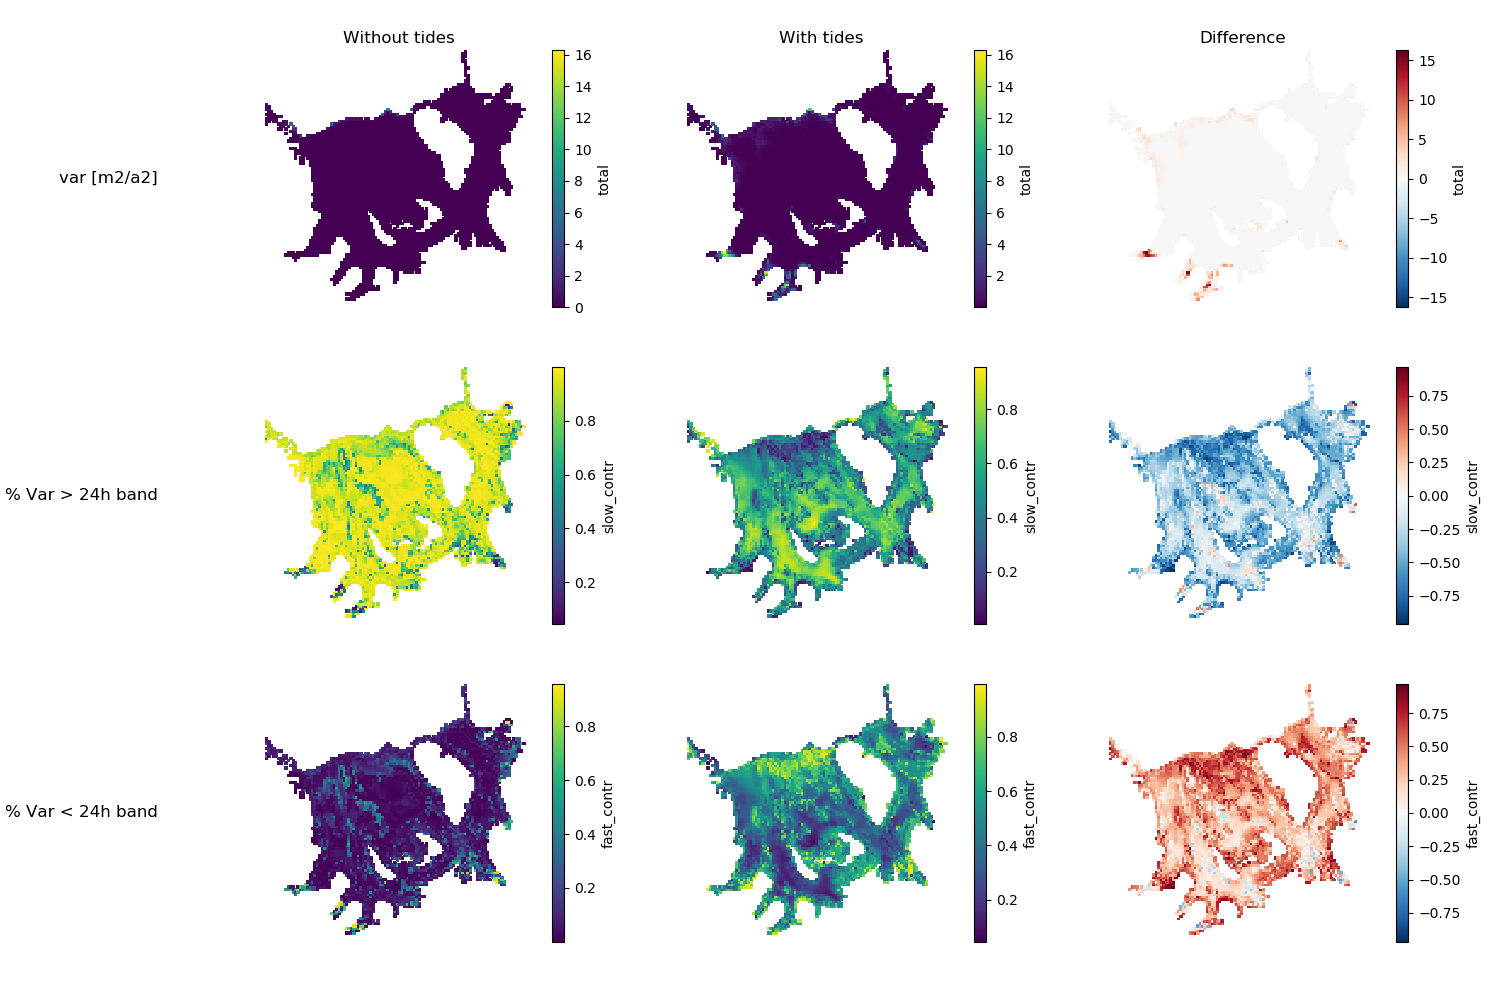

In [112]:
%matplotlib notebook
#plot variances of raw, low pass and high pass filtered signals
plt.close()
fig,axes = plt.subplots(ncols=3,nrows=3,figsize=(15,10))

#fig.suptitle('Variance of basal melting')

var_nt.total.plot(ax=axes[0,0],vmax=var_t.total.max().values)
#axes[0,0].set_title('Variance of raw signal')

var_t.total.plot(ax=axes[0,1])
#axes[0,1].set_title('Variance of raw signal')

var_nt.slow_contr.plot(ax=axes[1,0])
#axes[1,0].set_title('%var explained by > 24h')

var_t.slow_contr.plot(ax=axes[1,1])
#axes[1,1].set_title('%var explained by > 24h')

var_nt.fast_contr.plot(ax=axes[2,0])
#axes[2,0].set_title('% var explained by < 24h')

var_t.fast_contr.plot(ax=axes[2,1])
#axes[2,1].set_title('%var explained by < 24h')

((var_t.total-var_nt.total)).plot(ax=axes[0,2])

((var_t.slow_contr-var_nt.slow_contr)).plot(ax=axes[1,2])

((var_t.fast_contr-var_nt.fast_contr)).plot(axes=axes[2,2])

for ax in axes.flatten():
    ax.set_aspect('equal')
    ax.axis('off')

cols = ['Without tides','With tides','Difference']
rows = ['var [m2/a2]','% Var > 24h band','% Var < 24h band']

pad = 5 # in points

for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')

fig.tight_layout()
# tight_layout doesn't take these labels into account. We'll need 
# to make some room. These numbers are are manually tweaked. 
# You could automatically calculate them, but it's a pain.
fig.subplots_adjust(left=0.15, top=0.95)
    
plt.show()
#add column of differences

In [4]:
FRIS = no_tides.isel(xi_rho = slice(270,380),eta_rho = slice(380,486))
m_raw = FRIS.m.where((FRIS.zice < 0.0)&(FRIS.mask_rho==1))

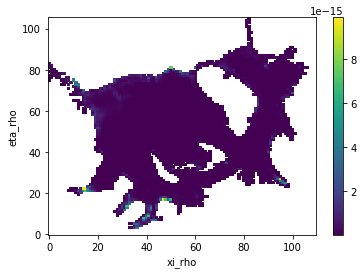

In [6]:
plt.close()
m_raw.var('ocean_time').plot()
plt.show()